### Lables: XML to COCO

In [ ]:
import os
import xml.etree.ElementTree as ET
from pathlib import Path

def convert_xml_to_yolo(xml_folder, output_folder, class_mapping={'pool': 0}):
    os.makedirs(output_folder, exist_ok=True)
    
    xml_files = list(Path(xml_folder).glob('*.xml'))
    
    if not xml_files:
        print(f"Aucun fichier XML trouvé dans {xml_folder}")
        return
    
    converted_count = 0
    
    for xml_file in xml_files:
        try:
            tree = ET.parse(xml_file)
            root = tree.getroot()
            
            size = root.find('size')
            img_width = int(size.find('width').text)
            img_height = int(size.find('height').text)
            
            yolo_lines = []
            
            for obj in root.findall('object'):
                class_name = obj.find('name').text
                
                if class_name not in class_mapping:
                    print(f"Attention: classe '{class_name}' non trouvée dans le mapping, ignorée")
                    continue
                
                class_id = class_mapping[class_name]
                
                bndbox = obj.find('bndbox')
                xmin = float(bndbox.find('xmin').text)
                ymin = float(bndbox.find('ymin').text)
                xmax = float(bndbox.find('xmax').text)
                ymax = float(bndbox.find('ymax').text)
                
                center_x = ((xmin + xmax) / 2) / img_width
                center_y = ((ymin + ymax) / 2) / img_height
                width = (xmax - xmin) / img_width
                height = (ymax - ymin) / img_height
                
                yolo_lines.append(f"{class_id} {center_x:.6f} {center_y:.6f} {width:.6f} {height:.6f}")
            
            output_file = Path(output_folder) / f"{xml_file.stem}.txt"
            with open(output_file, 'w') as f:
                f.write('\n'.join(yolo_lines))
            
            converted_count += 1
            
        except Exception as e:
            print(f"Erreur lors de la conversion de {xml_file.name}: {e}")
    
    print(f"\n✓ Conversion terminée: {converted_count}/{len(xml_files)} fichiers convertis")
    print(f"✓ Fichiers YOLO sauvegardés dans: {output_folder}")

xml_folder = './CANNES_TILES_512x512_labels'
output_folder = './CANNES_TILES_512x512_yolo_labels'

class_mapping = {
    'pool': 0
}

convert_xml_to_yolo(xml_folder, output_folder, class_mapping)



✓ Conversion terminée: 1224/1224 fichiers convertis
✓ Fichiers YOLO sauvegardés dans: ./CANNES_TILES_512x512_yolo_labels


### Generating empty label files

In [ ]:
import os
from pathlib import Path

def create_empty_labels_for_unlabeled_images(images_folder, labels_folder, image_extensions=['.png', '.jpg', '.jpeg', '.tif']):
    images_path = Path(images_folder)
    labels_path = Path(labels_folder)
    
    os.makedirs(labels_path, exist_ok=True)
    
    created_count = 0
    
    for ext in image_extensions:
        for image_file in images_path.glob(f'*{ext}'):
            label_file = labels_path / f"{image_file.stem}.txt"
            
            if not label_file.exists():
                label_file.touch()
                created_count += 1
    
    print(f"✓ {created_count} fichiers labels vides créés pour les images sans annotations")


In [ ]:
images_folder = './CANNES_TILES_512x512_PNG'
labels_folder = './CANNES_TILES_512x512_yolo_labels'
create_empty_labels_for_unlabeled_images(images_folder, labels_folder)

### Data samples visualisation

In [ ]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path

def plot_yolo_annotations(image_path, label_path, class_names={0: 'pool'}):
    img = cv2.imread(str(image_path))
    if img is None:
        print(f"Erreur: impossible de charger l'image {image_path}")
        return
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width = img_rgb.shape[:2]
    
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img_rgb)
    
    if Path(label_path).exists():
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    class_id = int(parts[0])
                    center_x = float(parts[1]) * width
                    center_y = float(parts[2]) * height
                    box_width = float(parts[3]) * width
                    box_height = float(parts[4]) * height
                    
                    x = center_x - box_width / 2
                    y = center_y - box_height / 2
                    
                    rect = patches.Rectangle((x, y), box_width, box_height,
                                            linewidth=2, edgecolor='red', facecolor='none')
                    ax.add_patch(rect)
                    
                    class_name = class_names.get(class_id, f'Class {class_id}')
                    ax.text(x, y - 5, class_name, 
                           bbox=dict(facecolor='red', alpha=0.7),
                           fontsize=10, color='white', weight='bold')
        
        print(f"✓ Annotations chargées depuis: {label_path}")
    else:
        print(f"⚠ Aucun fichier label trouvé: {label_path}")
    
    ax.axis('off')
    plt.title(f'Image avec annotations YOLO - {Path(image_path).name}')
    plt.tight_layout()
    plt.show()


✓ Annotations chargées depuis: ./CANNES_TILES_512x512_yolo_labels/CANNES_TILES_512x512.47.txt


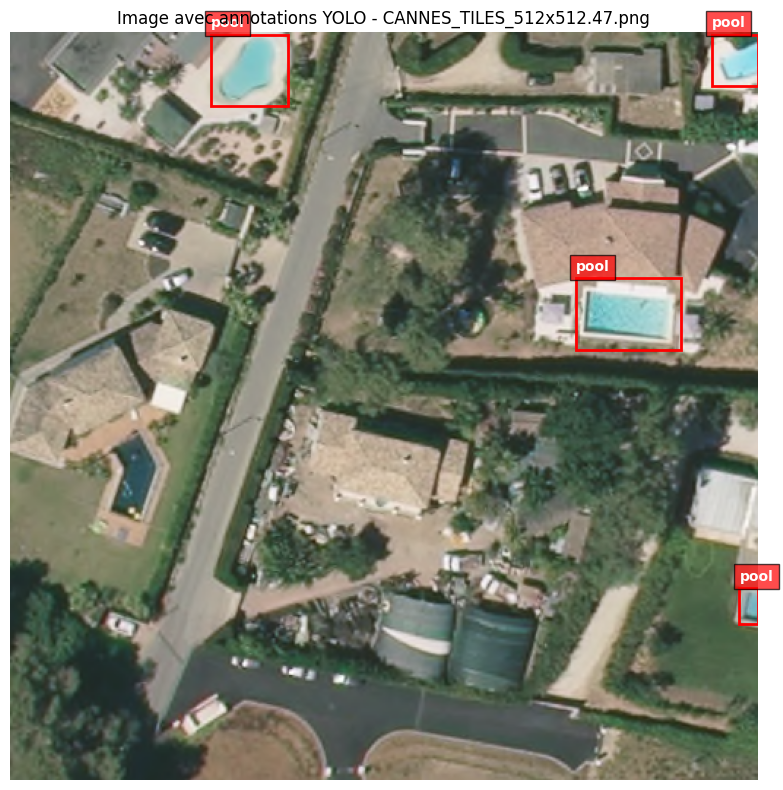

In [ ]:
image_path = './CANNES_TILES_512x512_PNG/CANNES_TILES_512x512.47.png'
label_path = './CANNES_TILES_512x512_yolo_labels/CANNES_TILES_512x512.47.txt'

class_names = {0: 'pool'}

plot_yolo_annotations(image_path, label_path, class_names)


### Data split

In [ ]:
import os
import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split
import yaml

def split_dataset_for_yolo(images_folder, labels_folder, output_folder, 
                          train_ratio=0.7, val_ratio=0.2, test_ratio=0.1,
                          class_names=['pool'], random_state=42):
    images_path = Path(images_folder)
    labels_path = Path(labels_folder)
    output_path = Path(output_folder)
    
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 0.01, "Les ratios doivent sommer à 1.0"
    
    image_extensions = ['.png', '.jpg', '.jpeg', '.tif', '.tiff', '.bmp']
    all_images = []
    for ext in image_extensions:
        all_images.extend(list(images_path.glob(f'*{ext}')))
    
    if not all_images:
        print(f"❌ Aucune image trouvée dans {images_folder}")
        return
    
    print(f"📊 Nombre total d'images: {len(all_images)}")
    
    splits = ['train', 'val', 'test']
    for split in splits:
        (output_path / 'images' / split).mkdir(parents=True, exist_ok=True)
        (output_path / 'labels' / split).mkdir(parents=True, exist_ok=True)
    
    train_images, temp_images = train_test_split(
        all_images, 
        test_size=(1 - train_ratio),
        random_state=random_state
    )
    
    val_size = val_ratio / (val_ratio + test_ratio)
    val_images, test_images = train_test_split(
        temp_images,
        test_size=(1 - val_size),
        random_state=random_state
    )
    
    split_data = {
        'train': train_images,
        'val': val_images,
        'test': test_images
    }
    
    print(f"\n📁 Division du dataset:")
    print(f"  • Train: {len(train_images)} images ({train_ratio*100:.0f}%)")
    print(f"  • Val:   {len(val_images)} images ({val_ratio*100:.0f}%)")
    print(f"  • Test:  {len(test_images)} images ({test_ratio*100:.0f}%)")
    
    for split_name, images in split_data.items():
        print(f"\n🔄 Copie des fichiers {split_name}...")
        
        for img_file in images:
            dest_img = output_path / 'images' / split_name / img_file.name
            shutil.copy2(img_file, dest_img)
            
            label_file = labels_path / f"{img_file.stem}.txt"
            if label_file.exists():
                dest_label = output_path / 'labels' / split_name / label_file.name
                shutil.copy2(label_file, dest_label)
            else:
                dest_label = output_path / 'labels' / split_name / f"{img_file.stem}.txt"
                dest_label.touch()
    
    data_yaml = {
        'path': str(output_path.absolute()),
        'train': 'images/train',
        'val': 'images/val',
        'test': 'images/test',
        'nc': len(class_names),
        'names': class_names
    }
    
    yaml_path = output_path / 'data.yaml'
    with open(yaml_path, 'w') as f:
        yaml.dump(data_yaml, f, default_flow_style=False, sort_keys=False)
    
    print(f"\n✅ Dataset divisé avec succès!")
    print(f"✅ Fichier data.yaml créé: {yaml_path}")
    print(f"\n📂 Structure créée dans: {output_path}")
    print(f"   ├── images/")
    print(f"   │   ├── train/ ({len(train_images)} images)")
    print(f"   │   ├── val/ ({len(val_images)} images)")
    print(f"   │   └── test/ ({len(test_images)} images)")
    print(f"   ├── labels/")
    print(f"   │   ├── train/")
    print(f"   │   ├── val/")
    print(f"   │   └── test/")
    print(f"   └── data.yaml")


In [ ]:
images_folder = './CANNES_TILES_512x512_PNG'
labels_folder = './CANNES_TILES_512x512_yolo_labels'
output_folder = './dataset_yolo'

split_dataset_for_yolo(
    images_folder=images_folder,
    labels_folder=labels_folder,
    output_folder=output_folder,
    train_ratio=0.7,    
    val_ratio=0.2,     
    test_ratio=0.1,    
    class_names=['pool']
)


📊 Nombre total d'images: 2401

📁 Division du dataset:
  • Train: 1680 images (70%)
  • Val:   480 images (20%)
  • Test:  241 images (10%)

🔄 Copie des fichiers train...

🔄 Copie des fichiers val...

🔄 Copie des fichiers test...

✅ Dataset divisé avec succès!
✅ Fichier data.yaml créé: dataset_yolo\data.yaml

📂 Structure créée dans: dataset_yolo
   ├── images/
   │   ├── train/ (1680 images)
   │   ├── val/ (480 images)
   │   └── test/ (241 images)
   ├── labels/
   │   ├── train/
   │   ├── val/
   │   └── test/
   └── data.yaml


### Model Training

In [ ]:
from ultralytics import YOLO

model = YOLO('yolo11l.pt')

results = model.train(
    data='./dataset_yolo/data.yaml', 
    epochs=100,                    
    imgsz=640,                   
    patience=10,   
    device=0,               
)

New https://pypi.org/project/ultralytics/8.3.246 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.171  Python-3.11.13 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1650 Ti, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./dataset_yolo/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, opti

train: Scanning C:\Users\ali_e\Documents\prjcts\swimming_pool_detection\dataset_yolo\labels\train... 1680 images, 841 backgrounds, 0 corrupt: 100%|██████████| 1680/1680 [00:03<00:00, 498.33it/s]


train: New cache created: C:\Users\ali_e\Documents\prjcts\swimming_pool_detection\dataset_yolo\labels\train.cache
val: Fast image access  (ping: 0.30.2 ms, read: 18.03.6 MB/s, size: 403.9 KB)


val: Scanning C:\Users\ali_e\Documents\prjcts\swimming_pool_detection\dataset_yolo\labels\val... 480 images, 221 backgrounds, 0 corrupt: 100%|██████████| 480/480 [00:02<00:00, 219.48it/s]

val: New cache created: C:\Users\ali_e\Documents\prjcts\swimming_pool_detection\dataset_yolo\labels\val.cache
